In [1]:
# !pip uninstall tensorflow
# !pip install --upgrade tensorflow
!pip install textsearch
!pip install contractions

  Stored in directory: C:\Users\GELab\AppData\Local\pip\Cache\wheels\0a\90\61\87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [163]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
# Project Path
%pwd
%cd drive/My Drive/ANLP-Project/
%pwd

[Errno 2] No such file or directory: 'drive/My Drive/ANLP-Project/'
/content/drive/My Drive/ANLP-Project


'/content/drive/My Drive/ANLP-Project'

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import re
import nltk
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import contractions
from sklearn.model_selection import train_test_split
pd.set_option("display.max_colwidth", 200)
# warnings.filterwarnings("ignore")
from Data.attention import AttentionLayer
# Downloads
nltk.download('stopwords')
nltk.download('punkt')

ModuleNotFoundError: No module named 'contractions'

In [0]:
assert(tf.__version__ == "2.0.0")

In [0]:
data_directory_path = "Data/"
reviews_data = data_directory_path + "Reviews.csv"

In [0]:
reviews_df = pd.read_csv(reviews_data,nrows=1000)
# reviews_df = pd.read_csv(reviews_data)

In [169]:
data_df = reviews_df.filter(items=["Summary","Text"])
data_df.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [0]:
data_df.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data_df.dropna(axis=0,inplace=True)#dropping na

In [171]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 999
Data columns (total 2 columns):
Summary    997 non-null object
Text       997 non-null object
dtypes: object(2)
memory usage: 23.4+ KB


In [0]:
stop_words = set(stopwords.words('english')) 

In [173]:
def clean_text(text_string, remove_stop_words=False):
    text_string = text_string.lower()
    tokenized_words = word_tokenize(text_string)

    # Remove stop words
    if remove_stop_words:
        tokenized_words = [word for word in tokenized_words if word not in stop_words]
    
    tokenized_words_str = " ".join(tokenized_words)
    
    tokenized_words_str = contractions.fix(tokenized_words_str)
    return tokenized_words_str


s = "If y'all are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda."
clean_text(s,True)

'you all looking secret ingredient robitussin believe found . got addition root beer extract ordered ( good ) made cherry soda .'

In [0]:
data_df["Text"] = data_df["Text"].apply(lambda x: clean_text(x))
data_df["Summary"] = data_df["Summary"].apply(lambda x: clean_text(x))

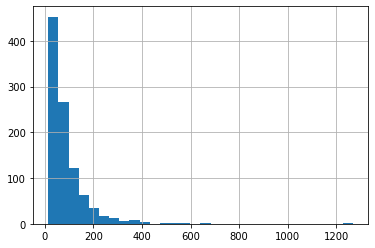

In [175]:
data_df["Text_len"] = data_df["Text"].apply(lambda x: len(x.split(" ")))
data_df["Text_len"].hist(bins=30)

max_text_len = 400

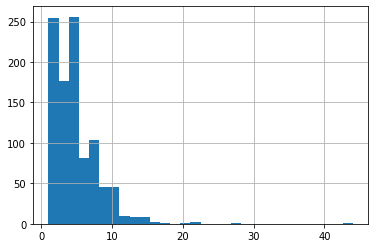

In [176]:
data_df["Summary_len"] = data_df["Summary"].apply(lambda x: len(x.split(" ")))
data_df["Summary_len"].hist(bins=30)
max_summary_len = 15

From the above Histograms, we have chosen maxlen for Text as 200 and Summary as 10
 

In [177]:
print(data_df.shape)
data_df = data_df[(data_df["Summary_len"] <= max_summary_len) & (data_df["Text_len"] <= max_text_len)]
data_df.shape

(997, 4)


(981, 4)

In [0]:
data_df['Summary'] = data_df['Summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [0]:
xTrain,xValid,yTrain,yValid=train_test_split(np.array(data_df['Text']),np.array(data_df['Summary']),test_size=0.2,random_state=0,shuffle=True)

tokenising and converting words in sentence as integer sequences
say the sentence 'hello world' is converted to [[0,1],[1,0]] given there are in total 2 distinct words in the entire corpus.



In [0]:
def getNumVocabWordsToBeKept(minReqFreqencyOfWords,tokenizer):

    numRareWords=0
    totalUniqueWords=0
    totalFreqWords = 0
    totalFreqOfRareWords = 0

    for word,freq in tokenizer.word_counts.items():
        totalUniqueWords += 1
        totalFreqWords += freq
        if(freq<minReqFreqencyOfWords):
            numRareWords += 1
            totalFreqOfRareWords+=freq

    print("% of rare words in vocabulary:",(numRareWords/totalUniqueWords)*100)
    print("Total Coverage of rare words:",(totalFreqOfRareWords/totalFreqWords)*100)

    return totalUniqueWords - numRareWords


In [181]:
## getting frequency for X
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(xTrain))

numReqXWords = getNumVocabWordsToBeKept(4,x_tokenizer)

% of rare words in vocabulary: 71.44255235858289
Total Coverage of rare words: 9.280343335461446


In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=numReqXWords) 
x_tokenizer.fit_on_texts(list(xTrain))

#convert text sequences into integer sequences
xTrain_seq    =   x_tokenizer.texts_to_sequences(xTrain) 
xValid_seq   =   x_tokenizer.texts_to_sequences(xValid)

#padding zero upto maximum length
xTrain    =   pad_sequences(xTrain_seq,  maxlen=max_text_len, padding='post')
xValid   =   pad_sequences(xValid_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
xVocab   =  x_tokenizer.num_words + 1

In [183]:
## getting frequency for Y
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(yTrain))
numReqYWords = getNumVocabWordsToBeKept(2,y_tokenizer)

% of rare words in vocabulary: 61.44329896907217
Total Coverage of rare words: 12.5


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=numReqYWords) 
y_tokenizer.fit_on_texts(list(yTrain))

#convert text sequences into integer sequences
yTrain_seq    =   y_tokenizer.texts_to_sequences(yTrain) 
yValid_seq   =   y_tokenizer.texts_to_sequences(yValid) 

#padding zero upto maximum length
yTrain    =   pad_sequences(yTrain_seq, maxlen=max_summary_len, padding='post')
yValid   =   pad_sequences(yValid_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
yVocab  =   y_tokenizer.num_words +1



##### deleting the rows that contain only START and END tokens

In [0]:

def removeRowsWithOnlyStartEnd(textSet,summarySet):
    """
    startEnd tokens are only in summarySet
    """
    ind=[]
    for i in range(len(summarySet)):
        cnt=0
        for j in summarySet[i]:
            if j!=0:
                cnt=cnt+1
        if(cnt==2):
            ind.append(i)

    summarySet=np.delete(summarySet,ind, axis=0)
    textSet=np.delete(textSet,ind, axis=0)
    return textSet,summarySet


In [0]:
xTrain,yTrain = removeRowsWithOnlyStartEnd(xTrain,yTrain)
xValid,yValid = removeRowsWithOnlyStartEnd(xValid,yValid)

In [187]:
len(y_tokenizer.index_word)

970

In [188]:
len(x_tokenizer.index_word)

5109

In [189]:
tf.keras.backend.clear_session()

latent_dim = 300
embedding_dim=100

########################### Encoder  #####################################
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(xVocab, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)



################################ decoder #############
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,)) ## target vector except the last token

#embedding layer
dec_emb_layer = Embedding(yVocab, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(yVocab, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

#Define the model 
FullModel = Model([encoder_inputs, decoder_inputs], decoder_outputs)

FullModel.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 100)     146000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 400, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
FullModel.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [192]:
history=FullModel.fit([xTrain,yTrain[:,:-1]], 
                  yTrain.reshape(yTrain.shape[0],yTrain.shape[1], 1)[:,1:] ,
                  epochs=10,callbacks=[es],batch_size=128, 
                  validation_data=([xValid,yValid[:,:-1]], yValid.reshape(yValid.shape[0],yValid.shape[1], 1)[:,1:]))

Train on 749 samples, validate on 180 samples
Epoch 1/10
749/749 [==============================] - 201s 268ms/sample - loss: 3.6978 - val_loss: 1.5649
Epoch 2/10
749/749 [==============================] - 192s 256ms/sample - loss: 1.7476 - val_loss: 1.4964
Epoch 3/10
749/749 [==============================] - 189s 252ms/sample - loss: 1.7169 - val_loss: 1.4420
Epoch 4/10
749/749 [==============================] - 189s 252ms/sample - loss: 1.6786 - val_loss: 1.4161
Epoch 5/10
384/749 [==============>...............] - ETA: 1:24 - loss: 1.5950WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


KeyboardInterrupt: ignored

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Inference
Set up the inference for the encoder and decoder:

In [0]:
## encoder only model so as to get the encoder outputs
encoder_model_inf = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

## after the encoder outputs,
decoder_state_input_h = Input(shape=(latent_dim,)) ## hidden state to be initialised , basically the last output of sequence
decoder_state_input_c = Input(shape=(latent_dim,)) ## cell state
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim)) ## all sequences required for attention 
dec_emb_inf = dec_emb_layer(decoder_inputs) ## getting the embedings in the summary

## extract decoder outputs for each word
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(dec_emb_inf, initial_state=[decoder_state_input_h, decoder_state_input_c]) 

## send the decoder output (1,latentDim) and encoder outputs (maxTextLen, latentDim) into attention layer to get final decoder output

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs_inf])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs_inf, attn_out_inf])
decoder_outputs_inf = decoder_dense(decoder_inf_concat) ## time distributed

# Final decoder model for inference
## decoder_inputs : target vector without last token, in this case a single word
decoder_model_inf = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_inf] + [state_h_inf, state_c_inf])



In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model_inf.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, new_h, new_c = decoder_model_inf.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) ## need to change this to beam search
        sampled_token = reverse_target_word_index[sampled_token_index+1]

        
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = new_h, new_c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [208]:
for i in range(0,5):
    print("Review:",seq2text(xTrain[i]))
    print("Original summary:",seq2summary(yTrain[i]))
    print("Predicted summary:",decode_sequence(xTrain[i].reshape(1,max_text_len))) 
    print("\n")

Review: these are the best tasting tuna pack they make in my opinion make a great on the go snack and really satisfying with the tomato 
Original summary: tasty 
Predicted summary:  the great great great sostok sostok sostok sostok sostok sostok sostok sostok sostok sostok


Review: what a deal this is the salt you can use this box should last our family the year no problem sea salt will not your blood as regular salt will 
Original summary: great deal 
Predicted summary:  the great great great sostok sostok sostok sostok sostok sostok sostok sostok sostok sostok


Review: mccann 's makes oatmeal for every oatmeal one likes it from the raw state that cooks for half an hour to the instant which can be done in the for under three minutes it 's all good that 's for sure and the of the instant variety is that it is available in different flavors as well as regular br this variety pack different tastes to be as well as giving you a to experience the difference between mccann 's and other we